# Main Code
All the functions and code for the extraction and analysis of the flight spare SXM angular response measurements

In [143]:
# Interval of bins (a,b)
a = 190
b = 221
c = 215  # approximate point where the two gaussians meet

In [148]:
import h5py
import os
import sys
from glob import glob
from math import factorial
from numpy import genfromtxt, sum, array,sqrt,zeros,exp,diag, pi,arange, sin, cos,vstack,log, mean, ones
from pylab import show, savefig, errorbar, scatter,legend, colorbar, xlabel, ylabel, title, imshow,plot, subplot, axvspan,xlim,ylim,stem,setp
from matplotlib import gridspec
from scipy.optimize import curve_fit


# Interval of bins (a,b)
#a = 190
#b = 221
#c = 210  # approximate point where the two gaussians meet

############################## Functions for calculations and plots ##############################


def sort_and_split_by_time(events,remover=0):
    sortedEvents = sort_mesurements_by_time(events,remover)
    values = 1
    for i in range(len(sortedEvents)):
        if i != (len(sortedEvents)-1):
            if sortedEvents[i][1] != sortedEvents[i+1][1]:
              values +=1

    splitEventList = []
    for i in range(values):
        splitEventList.append([])

    n = 0
    for i in range(values):
        splitEventList[i].append(sortedEvents[n])
        n +=1
        for j in range(n,len(sortedEvents)):
            if sortedEvents[j][1] == splitEventList[i][-1][1]:
                splitEventList[i].append(sortedEvents[j])
                n += 1
            else:
                break

    return splitEventList


# Sorts histograms from shortest time to longest
def sort_mesurements_by_time(events, remover=0):
    # Parameters--|
    # ---------------------------------------------------------
    # event       | list => [counts (1D array), time, filenames]
    # ---------------------------------------------------------
    # Returns-----|
    # ---------------------------------------------------------
    # eventsByTime| list => [counts (1D array), time, filenames]

    eventsByTime = []
    temp = []
    addedFiles = []

    # Sort data
    for i in events:
        temp.append(i[1])
    while len(temp) != 0:
        for j in events:
            if j[1] == min(temp) and (j[2] not in addedFiles):
                eventsByTime.append(j)
                addedFiles.append(j[2])
                temp.remove(min(temp))
                break
    indexList = []
    if remover==1:
        for i in range(len(eventsByTime)):
            if max(eventsByTime[i][0]) < 10:
                indexList.append(i)
        m = 0
        for n in indexList:
            eventsByTime.pop(n-m)
            m += 1
    return eventsByTime


# Gaussian curve equation function
def gaussian_curve(x, a, p, w):
    # Parameters |
    #---------------------------
    # x          | bin number
    # a          | amplitude
    # p          | peak pos.
    # w          | width

    # return a*exp(-((x-p)**2)/(2*w**2)         # Regular gaussian
    return a*exp(-(4*log(2)*(x-p)**2)/(w**2))   # In terms of FWTM


# Returns the reduced Chi Square for a fit
def chi2_test(observed,expected,wholeFit=0):
    # Parameters |
    #-------------------------------------------
    # observed   | array/list of measured values
    # expected   | array/list of the fit
    # wholeFit   | = 0 for individual Gaussian fits
    # ^^^^^^^^^^^| = 1 for both Gaussians fit

    chi2 = 0
    for i in range(len(observed)):
        chi2 += ((observed[i]-expected[i])**2)/expected[i]
    if wholeFit:
        return chi2/(len(observed)-6)
    else:
        return chi2 / (len(observed) - 3)


# Returns the values corresponding to a Poisson function
def poisson_distribution(ocurrences,rate):
    # Parameters |
    #-------------------------
    # ocurrences | number of counts
    # rate       | count rate

    return (rate**ocurrences)/(factorial(ocurrences)*exp(rate))


# Plots the frequency of measurement of each count value
def count_frecuency(bns, allCPS):
    # Parameters |
    #-------------------------------------------
    # bns        | list => [multidimensional arrays (bins)]
    # allCPS     | list/array => [counts per second on each bin]

    counts = []
    reps = []
    frec = []
    totalMeasurements = 0
    for i in bns:
        for j in range(i.shape[0]):
            for k in range(i.shape[1]):
                c = i[j][k]
                if c not in counts:
                    counts.append(c)
                    reps.append(1)
                else:
                    n = counts.index(c)
                    reps[n] += 1
        totalMeasurements += i.shape[0]*i.shape[1]
    for i in reps:
        frec.append(float(i)/totalMeasurements)
    scatter(counts,frec)

    averageCPS = mean(array(allCPS))
    fit = []
    for i in range(len(counts)):
        fit.append(poisson_distribution(i,averageCPS))
    plot(counts,fit,"--r", label="Poisson dist.", zorder=1)
    chi2 = chi2_test(frec,fit)
    print chi2
    xlabel("Counts")
    ylabel("Frequency")
    legend(loc="upper right")
    title("Count frequency")
    show()


# Returns a list with the fit values
def gaussian_fit(y, t1, t2, t3, x1, x2,fullRange=1):
    # Parameters |
    #--------------------------------------------------
    # y          | list/array of measured y values
    # t1         | test parameter 1 (amplitude)
    # t2         | test parameter 2 (peak position
    # t3         | test parameter 3 (width)
    # x1         | start of interval to find fit param.
    # x2         | end of interval
    # fullRange  | = 1 returns fit values from a to b
    #^^^^^^^^^^^^| = 0 returns fit values from x2 to x2

    initValues = [t1,t2,t3]

    fitValues = curve_fit(gaussian_curve,range(x1,x2),y,p0 = initValues)

    amp = fitValues[0][0]
    pkPos = fitValues[0][1]
    width = fitValues[0][2]

    paramErrors = sqrt(diag(fitValues[1]))

    ampErr = paramErrors[0]
    pkPosErr = paramErrors[1]
    widthErr = paramErrors[2]

    fit = []
    if fullRange:
        for i in range(a,b):
            fit.append(gaussian_curve(i,amp,pkPos,width))
    else:
        for i in range(x1,x2):
            fit.append(gaussian_curve(i,amp,pkPos,width))
    fitData = [fit,amp,pkPos,width, ampErr,pkPosErr,widthErr]
    return fitData


# Plot bin histogram image
def plot_bin(bns, sect=0):
    # Parameters |
    #------------------------------------------------------
    # bns        | list => [multidimensional arrays (bins)]

    imshow(vstack(bns), origin='0', aspect="auto",cmap="plasma")
    if sect==1:
        axvspan(0,a, alpha=0.30, facecolor="black")               # Highlight selected
        axvspan(b,len(bns[1][0])-1, alpha=0.3, facecolor="black") # interval
    ylabel("Periods")
    xlabel("Bins")
    colorbar().set_label("Counts")


# Plot the angular response
def plot_angular_response(az, el, cps):
    # Parameters |
    #------------------------------------------------------
    # az         | list containing azimuth values
    # el         | list containing elevation values
    # cps        | list containing counts per second values

    angle = arange(0, 2 * pi, 0.01)
    for i in range(0,36,5):
        plot(i * cos(angle), i * sin(angle), "--k", alpha=0.25, zorder=1)

    scatter(az, el, c=cps, zorder=2,cmap="plasma")
    # title("SXM Angular Response (bins " + str(a) + " to " + str(b) + ")")
    xlabel("Azimuth (deg)")
    ylabel("Elevation (deg)")
    xlim(-40,40)
    ylim(-40,40)
    colorbar().set_label("Counts/sec")


# Plot 2 gaussian fits for the data
def fit_events_rms(events, returnFitParam=0, noRMS=0, remover=0):
    # Parameters     |
    #--------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]
    # returnFitParam | = 0 plots the 2 gaussian fits
    # ^^^^^^^^^^^^^^^| = 1 returns list with fit parameters

    s = zeros(len(events[0][0]), float)
    if noRMS==0:
        for i in range(len(events)):
            # Sum squares
            s += (events[i][0])**2
        m = s / len(events)
        rms = sqrt(m)
    elif noRMS==1:
        for i in range(len(events)):
            s += (events[i][0])
        rms = s

    amp1 = max(rms)
    pkPos1 = a+list(rms).index(max(rms))
    width1 = 10

    amp2 = max(rms[int(pkPos1)-a+10:])
    pkPos2 = pkPos1+10
    width2 = 10

    fit1Data = gaussian_fit(rms[:(c-a)],amp1,pkPos1,width1,a,c)
    fit2Data = gaussian_fit(rms[(c-a):],amp2,pkPos2,width2,c,b)

    rmsFit1 = fit1Data[0]
    rmsFit2 = fit2Data[0]
    fitSum = array(rmsFit1)+array(rmsFit2)

    #chi2Fit1 = chisquare(rms[:(c-a)],rmsFit1[:(c-a)])[0]
    #chi2Fit2 = chisquare(rms[(c-a):],rmsFit2[(c-a):])[0]

    chi2Fit1 = chi2_test(rms[:(c-a)],rmsFit1[:(c-a)])
    chi2Fit2 = chi2_test(rms[(c-a):],rmsFit2[(c-a):])
    chi2FitSum = chi2_test(rms,fitSum)

    if returnFitParam:
        return [[fit1Data,chi2Fit1],[fit2Data,chi2Fit2], chi2FitSum]
    else:

        plot(range(a, b), rms, "--o", label="RMS", zorder=1)
        plot(range(a, b), rmsFit1, "--", label=r"Fit 1 ($\chi^2$ = " +str(round(chi2Fit1,2)) + ")")
        plot(range(a, b), rmsFit2, "--", label=r"Fit 2 ($\chi^2$= " + str(round(chi2Fit2,2)) + ")")

        plot(range(a,b),fitSum, "--", label="Sum ($\chi^2$ = " +str(round(chi2FitSum,2)) + ")")
        legend(loc="upper right")
        #xlabel("Bin Number")
        ylabel("Counts")


# Plot counts vs bins for each individual bin array
def plot_events_all(events, removeBad=0, ordered=0,fit=0):
    # Parameters     |
    #--------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]
    
    if ordered==1:
        if removeBad==0:
            eventsByTime = sort_mesurements_by_time(events)
        elif removeBad == 1:
            eventsByTime = sort_mesurements_by_time(events,1)
    elif ordered==0:
        eventsByTime=events
    
    n=0
    for i in eventsByTime:
        subplot(5,8,n+1)
        plot(range(a,b),i[0], label = str(i[1])+" sec")
        
        if fit==1:
            amp = max(i[0])
            pkPos = a + list(i[0]).index(max(i[0]))
            width = 10
            fit = gaussian_fit(i[0], amp, pkPos, width, a, b)[0]

            chi2 = chi2_test(i[0],fit)
            plot(range(a, b), fit, "--", label="Fit ($\chi^2$= " + str(round(chi2,2)) + ")")
            
        title(str(n+1), fontweight='bold')
        legend(loc="upper right")
        n+=1
    show()


# Plot counts vs bins for the RMS of several bin arrays
def fit_sections_rms(events, countsOnly=0, groupByTime=0,remover=0):
    # Parameters     |
    #--------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]

    if groupByTime==0:
        eventsByTime = sort_mesurements_by_time(events,remover)
        n=0
        m=0
        for i in range(0,len(eventsByTime), 6):
            subplot(3, 3, n + 1)
            eventSection = eventsByTime[i:i+6]
            if countsOnly == 0:
                fit_events_rms(eventSection)
            elif countsOnly == 1:
                fit_events_rms(eventSection,0,1)
            m+=len(eventSection)
            # title(str(i+1)+" to "+str(m))
            n+=1
    if groupByTime==1:

        eventsByTime = sort_and_split_by_time(events, remover)  # [:(len(sort_and_split_by_time(events,remover)))-2]
        eventsByTime.pop(len(eventsByTime) - 2)
        n=0
        for i in eventsByTime:
            subplot(3, 3, n + 1)
            fit_events_rms(i,0,0)
            n +=1
            title(str(i[0][1])+"s")

    show()


# Plot RMS fits and residuals
def rms_fit_and_residual_fit(events,s,mode=0, remover=0, groupByTime=0):
    # Parameters     |
    # ------------------------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]
    # mode           | = 0 plot by sections
    # ^^^^^^^^^^^^^^^| = 1 plot for the overall RMS
    # ^^^^^^^^^^^^^^^| = 2 plot for overall RMS to be put along hist and ag response

    if mode == 1:
        if groupByTime == 0:
            eventsByTime = sort_mesurements_by_time(events,remover)
            if mode == 1:
                n = 0
                m = 0
                outerGrid = gridspec.GridSpec(2,5)
                for i in range(0, len(eventsByTime), s):
                    innerGrid = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=outerGrid[n])

                    eventSection = eventsByTime[i:i + s]
                    sp1 = subplot(innerGrid[0])
                    m += len(eventSection)
                    title(str(i+1)+" to "+str(m), fontweight='bold')
                    fit_events_rms(eventSection)
                    sp2 = subplot(innerGrid[1])
                    plot_residual_fit(eventSection)
                    setp(sp1.get_xticklabels(), visible=False)
                    n += 1
                show()

        elif groupByTime == 1:
            eventsByTime = sort_and_split_by_time(events, remover)  # [:(len(sort_and_split_by_time(events,remover)))-2]
            eventsByTime.pop(len(eventsByTime) - 2)
            n = 0
            outerGrid = gridspec.GridSpec(2, 3)
            for i in eventsByTime:
                innerGrid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outerGrid[n])
                sp1 = subplot(innerGrid[0])
                title(str(i[0][1]) + "s ("+str(len(i))+")",fontweight='bold')
                fit_events_rms(i,0,0,)
                sp2 = subplot(innerGrid[1])
                plot_residual_fit(i)
                setp(sp1.get_xticklabels(), visible=False)
                n += 1
            show()

    elif mode== 0:
        sp1 = subplot(211)
        title("All Events RMS")
        fit_events_rms(events)
        subplot(212,sharex=sp1)
        plot_residual_fit(events)
        setp(sp1.get_xticklabels(), visible=False)
        show()
    elif mode == 2:
        sp1 = subplot(426)
        title("All Events RMS")
        fit_events_rms(events)
        subplot(428, sharex=sp1)
        plot_residual_fit(events)
        setp(sp1.get_xticklabels(), visible=False)
        show()


# Plot fit with residual
def plot_residual_fit(events):
    # Parameters     |
    # -------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]

    
    s = zeros(len(events[0][0]), float)
    for i in range(len(events)):
        # Sum squares
        s += (events[i][0]) ** 2
    m = s / len(events)
    rms = sqrt(m)

    #plot(range(a, b), rms, "--o", label="RMS")

    amp1 = max(rms)
    pkPos1 = a + list(rms).index(max(rms))
    width1 = 10

    amp2 = max(rms[int(pkPos1) - a + 10:])
    pkPos2 = pkPos1 + 10
    width2 = 10

    rmsFit1 = gaussian_fit(rms[:(c - a)], amp1, pkPos1, width1, a, c)[0]
    rmsFit2 = gaussian_fit(rms[(c - a):], amp2, pkPos2, width2, c, b)[0]

    #totalFit = rmsFit1+rmsFit2
    totalFit = array(rmsFit1)+array(rmsFit2)
    
    chi2 = chi2_test(rms, totalFit,1)
    #plot(range(a,b),totalFit,"--r",label=r"Fit ($\chi^2$ = "+str(round(chi2,2))+")")


    residual = array(rms) - array(totalFit)
    stem(range(a,b),residual,"--c","oc", label="Residual") #(Avg = "+str(round(mean(residual),2))+")")
    xlabel("Bin Number")
    ylabel("Residual")
    legend(loc="upper right")


# Plot parameter data from the fits
def plot_fit_parameters(events, s=6, countsOnly=0, remover=0, groupByTime=0):
    # Parameters     |
    # -------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]
    # s              | int => number of histograms in one section

    listOfFitParameters = []
    if groupByTime==0:
        eventsByTime = sort_mesurements_by_time(events,remover)
        for i in range(0,len(eventsByTime), s):
            eventSection = eventsByTime[i:i + s]
            if countsOnly==0:
                listOfFitParameters.append(fit_events_rms(eventSection,1))
            elif countsOnly==1:
                listOfFitParameters.append(fit_events_rms(eventSection, 1, 1))
    elif groupByTime==1:
        eventsByTime = sort_and_split_by_time(events,remover) #[:(len(sort_and_split_by_time(events,remover)))-2]
        eventsByTime.pop(len(eventsByTime)-2)
        for i in eventsByTime:
            listOfFitParameters.append(fit_events_rms(i,1,0))


    chi2F1 = []
    ampF1 = []
    pkPosF1 = []
    widthF1 = []

    ampErrF1 = []
    pkPosErrF1 = []
    widthErrF1 = []

    chi2F2 = []
    ampF2 = []
    pkPosF2 = []
    widthF2 = []

    ampErrF2 = []
    pkPosErrF2 = []
    widthErrF2 = []
    
    sumChi2 = []

    for i in listOfFitParameters:      # listOfFitParameters[i]
        chi2F1.append(i[0][1])         # |__[[fit1Data,chi2Fit1],[fit2Data,chi2Fit2],chi2FitSum]
        ampF1.append(i[0][0][1])       #         |         |__number
        pkPosF1.append(i[0][0][2])     #         |____list => [i] = [fit,amp,pkPos,width,ampErr,pkPosErr,widthErr]
        widthF1.append(i[0][0][3])     #                         (from gaussian fit)
        ampErrF1.append(i[0][0][4])
        pkPosErrF1.append(i[0][0][5])
        widthErrF1.append(i[0][0][6])

        chi2F2.append(i[1][1])
        ampF2.append(i[1][0][1])
        pkPosF2.append(i[1][0][2])
        widthF2.append(i[1][0][3])
        ampErrF2.append(i[1][0][4])
        pkPosErrF2.append(i[1][0][5])
        widthErrF2.append(i[1][0][6])

        sumChi2.append(i[2])
        
    subplot(411)
    plot(sumChi2, label="$\chi^2$")
    legend(loc="upper left")
    
    sp1 = subplot(423)
    errorbar(range(len(pkPosF1)),pkPosF1,yerr=pkPosErrF1, color="r",label="Peak Position")
    #ylim(201, 204)
    title("Fit 1")
    legend(loc="upper left")

    subplot(223,sharex=sp1)
    setp(sp1.get_xticklabels(), visible=False)
    #plot(chi2F1, label="$\chi^2$")
    errorbar(range(len(ampF1)),ampF1,yerr=ampErrF1, label="Height")
    errorbar(range(len(widthF1)),widthF1, yerr=widthErrF1,label="Width")
    legend(loc="upper left")

    sp2 = subplot(424)
    errorbar(range(len(pkPosF2)),pkPosF2,yerr=pkPosErrF1, color ="r", label="Peak Position")
    #ylim(210, 215)
    title("Fit 2")
    legend(loc="upper left")

    subplot(224, sharex=sp2)
    setp(sp2.get_xticklabels(), visible=False)
    #plot(chi2F2, label="$\chi^2$")
    errorbar(range(len(ampF2)),ampF2, yerr=ampErrF2, label="Height")
    errorbar(range(len(widthF2)), widthF2, yerr=widthErrF2, label="Width")
    legend(loc="upper left")
    show()

    
############################## Data extraction from hdf5 files ##############################

h5FilesDir = "/home/cnieves/PycharmProjects/CfA/flight_spare_data/h5_files"
logfilesTablePath = "/home/cnieves/PycharmProjects/CfA/flight_spare_data/data_table.txt"

tableData = genfromtxt(logfilesTablePath, str)   # Data from angular response measurements

# Gets all the .h5 files from the specified directory
if h5FilesDir.endswith("/"):
    filePaths = sorted(glob(h5FilesDir + "*.h5"), key=os.path.getsize)
else:
    h5FilesDir += "/"
    filePaths = sorted(glob(h5FilesDir + "*.h5"), key=os.path.getsize)

countsPerSec = []     # Contains cps for each bin
elevation = []        # Values for elevation (deg)
azimuth = []          # Values for azimuth (deg)
binList = []          # Contains the arrays for each individual 'bin'
eventsTimeList = []   # [All counts, total time, name of the file] to be sorted by time
counts = []           # All counts on each 'bin' array
counts1 = []
bns = []

for i in filePaths:
    fileName = i[len(h5FilesDir):(len(i) - len(".h5"))]

    # Find files in the directory that match with the files on the table
    for m in tableData:
        if m[2] == fileName:  # m[2] is the logfile name on table

            # Calculate counts per second
            dataFile = h5py.File(i)
            binList.append(dataFile['data/tlm_sxm_data/hdr']['bin'])
            bins = dataFile['data/tlm_sxm_data/hdr']['bin'][:, a:b]
            dataFile.close()

            s = sum(bins, 1)
            totalTime = float(32 * len(s) / 2 + 18 * len(s) / 2)
            totalCounts = sum(bins)
            totalCounts1 = sum(bins[:35,:])
            cps = totalCounts / totalTime

            azimuth.append(float(m[0]))
            elevation.append(float(m[1]))
            countsPerSec.append(cps)
            eventsTimeList.append([sum(bins,0), totalTime, fileName])
            counts.append(totalCounts)
            counts1.append(totalCounts1)
            bns.append(bins)

# SXM Angular Response Summary

<IPython.core.display.Javascript object>


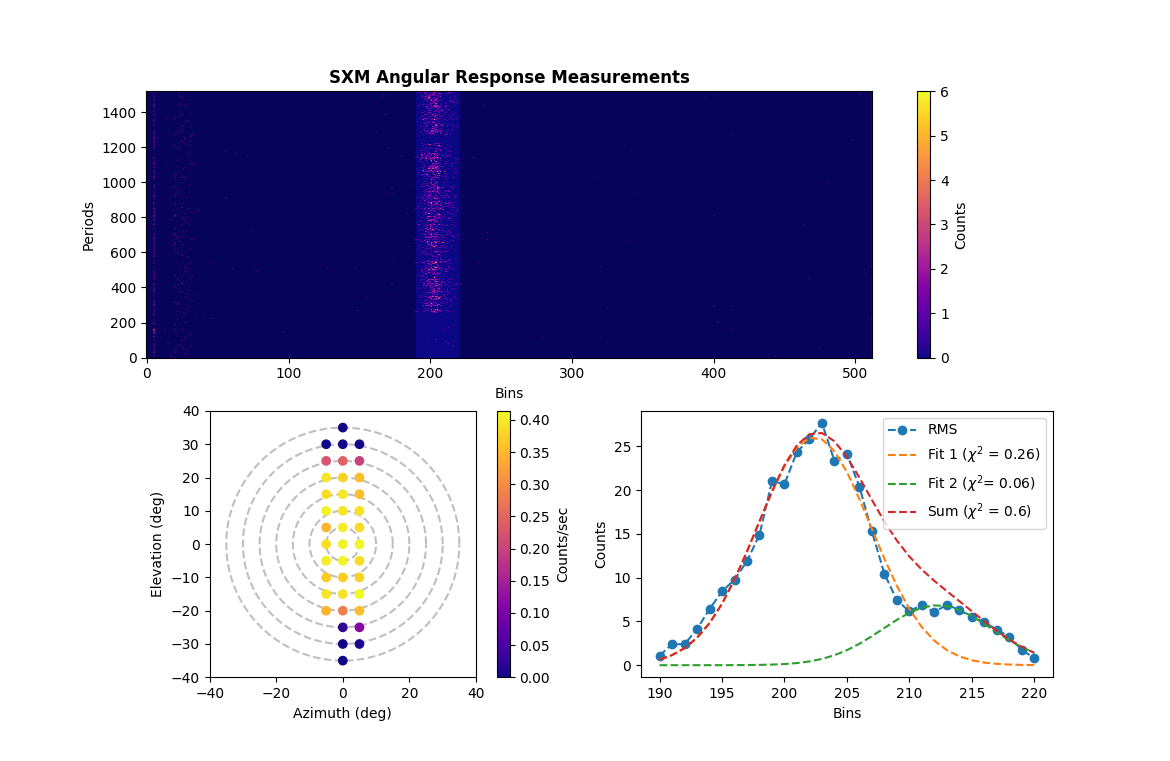

Text(0.5,0,u'Bins')

In [17]:
%matplotlib notebook

subplot(211)
plot_bin(binList,sect = 1)
title("SXM Angular Response Measurements", fontweight = 'bold')
subplot(223, aspect=1)
plot_angular_response(azimuth, elevation, countsPerSec)
sp = subplot(224)
fit_events_rms(eventsTimeList)
#subplot(428)
#plot_residual_fit(eventsTimeList)
#setp(sp.get_xticklabels(), visible=False)
xlabel("Bins")



# Count distribution

<IPython.core.display.Javascript object>


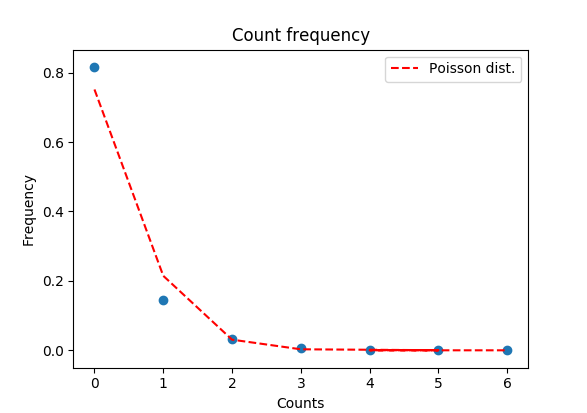

0.04078729651325849


In [11]:
%matplotlib notebook
count_frecuency(bns,sum(array(countsPerSec))/len(countsPerSec))

# All histograms
Not ordered

<IPython.core.display.Javascript object>


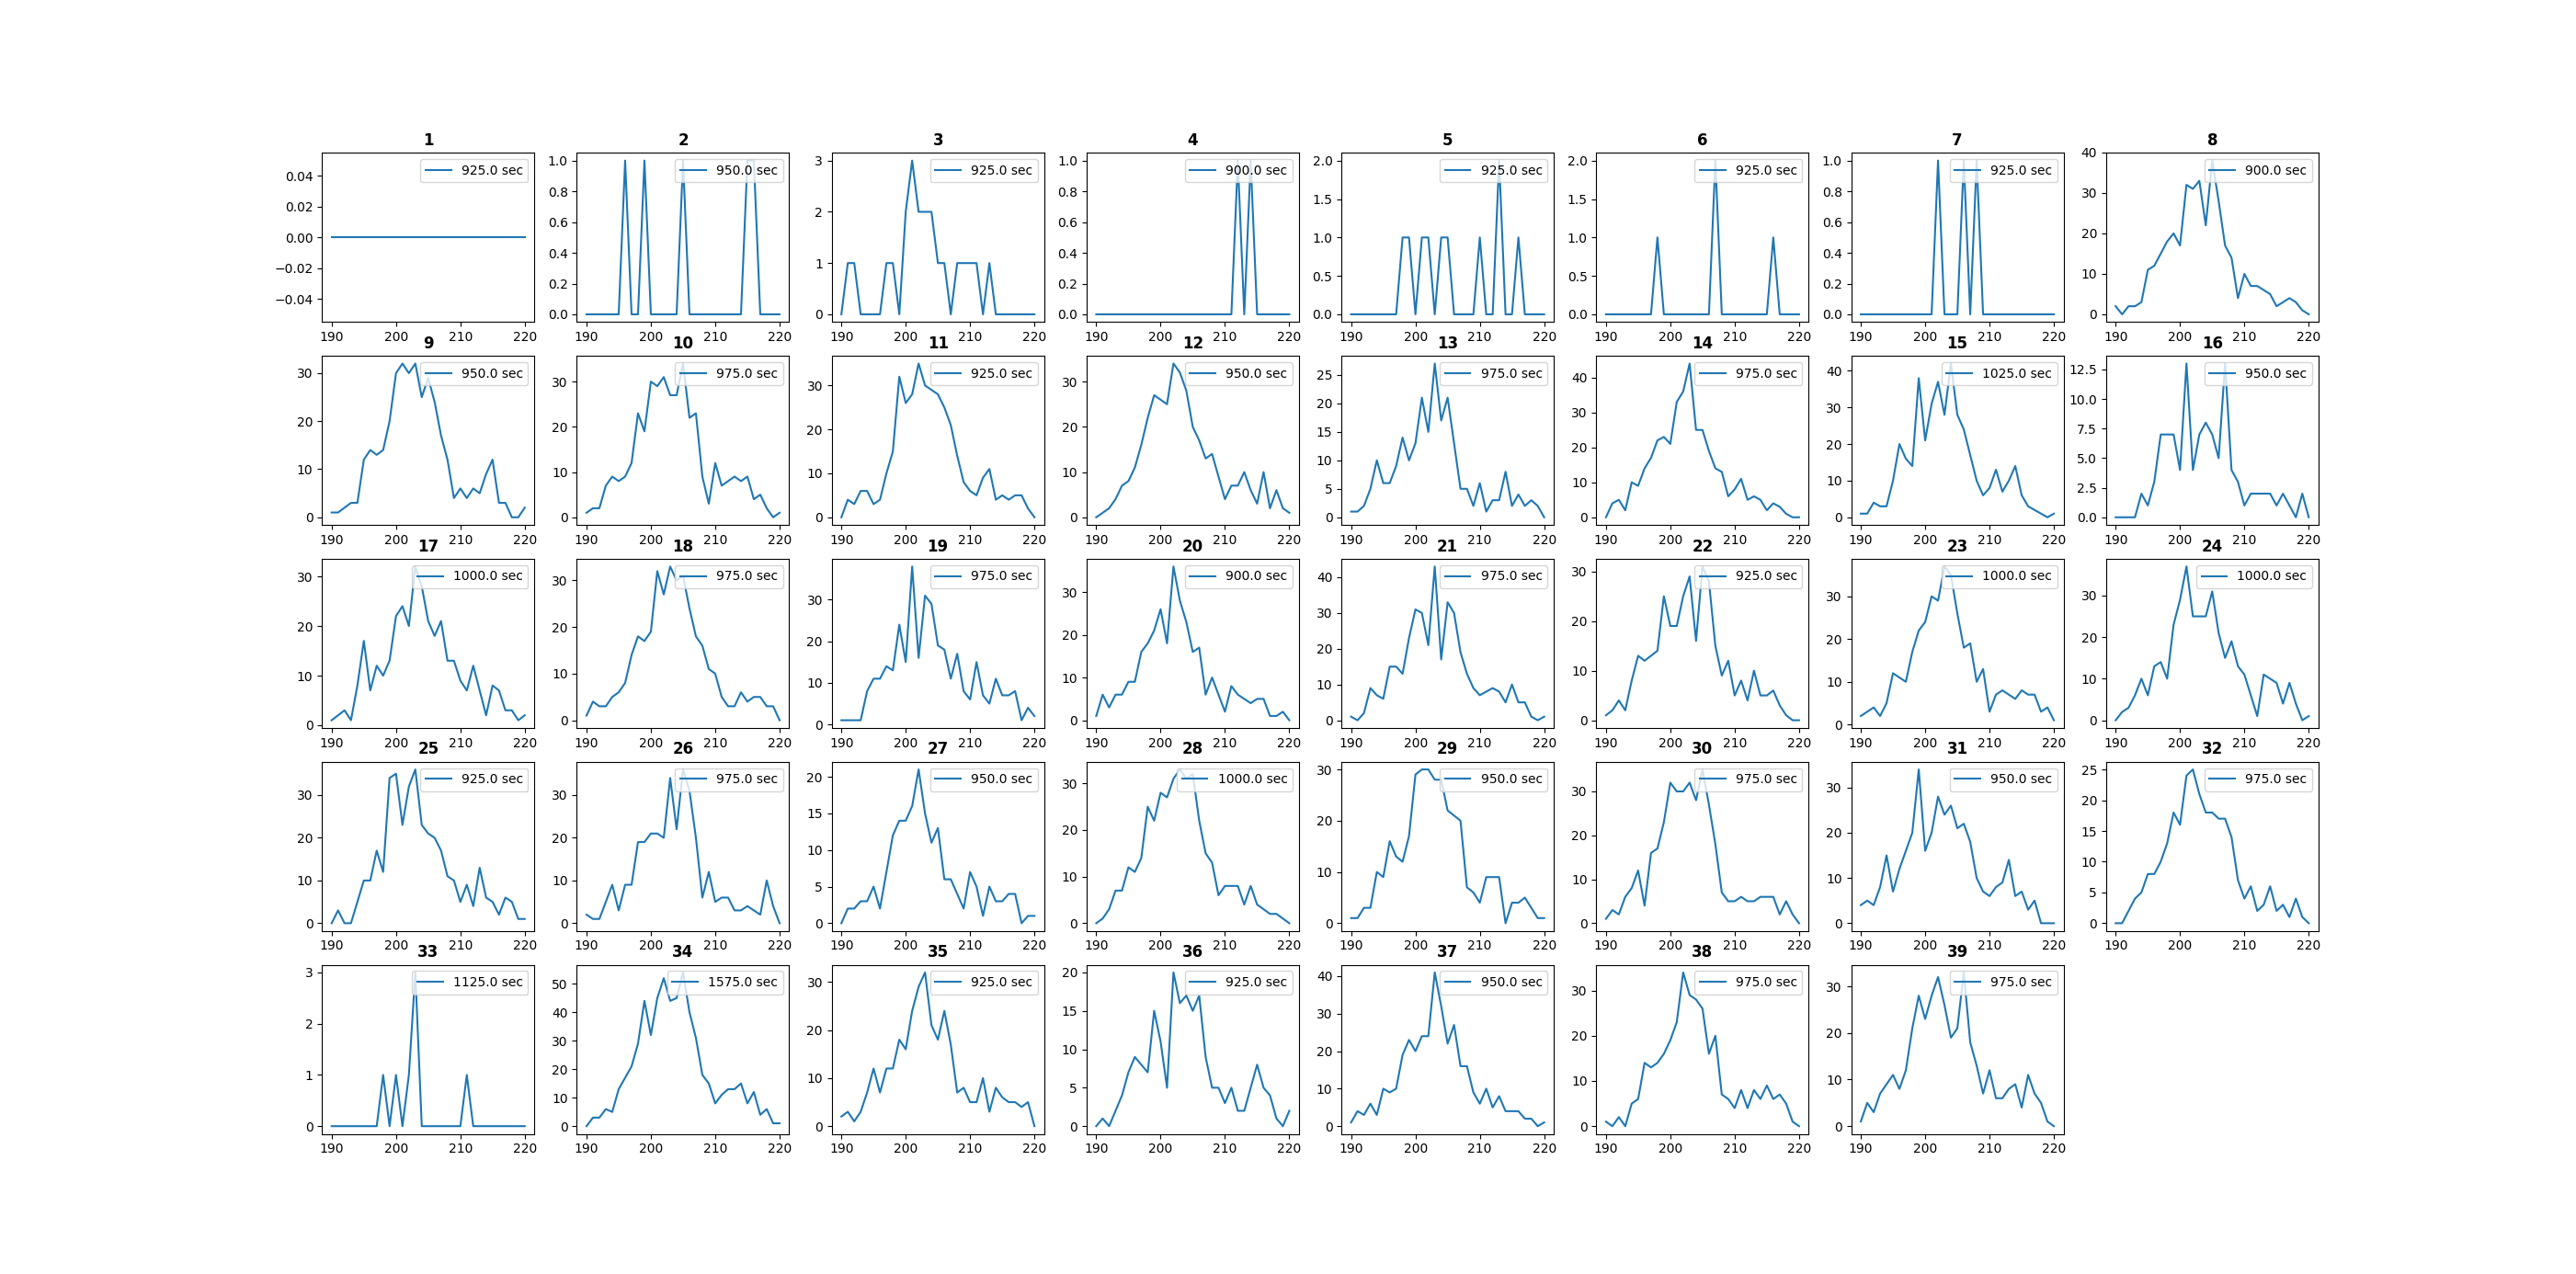

In [5]:
%matplotlib notebook
plot_events_all(eventsTimeList,0,0,0)

Ordered by time

<IPython.core.display.Javascript object>


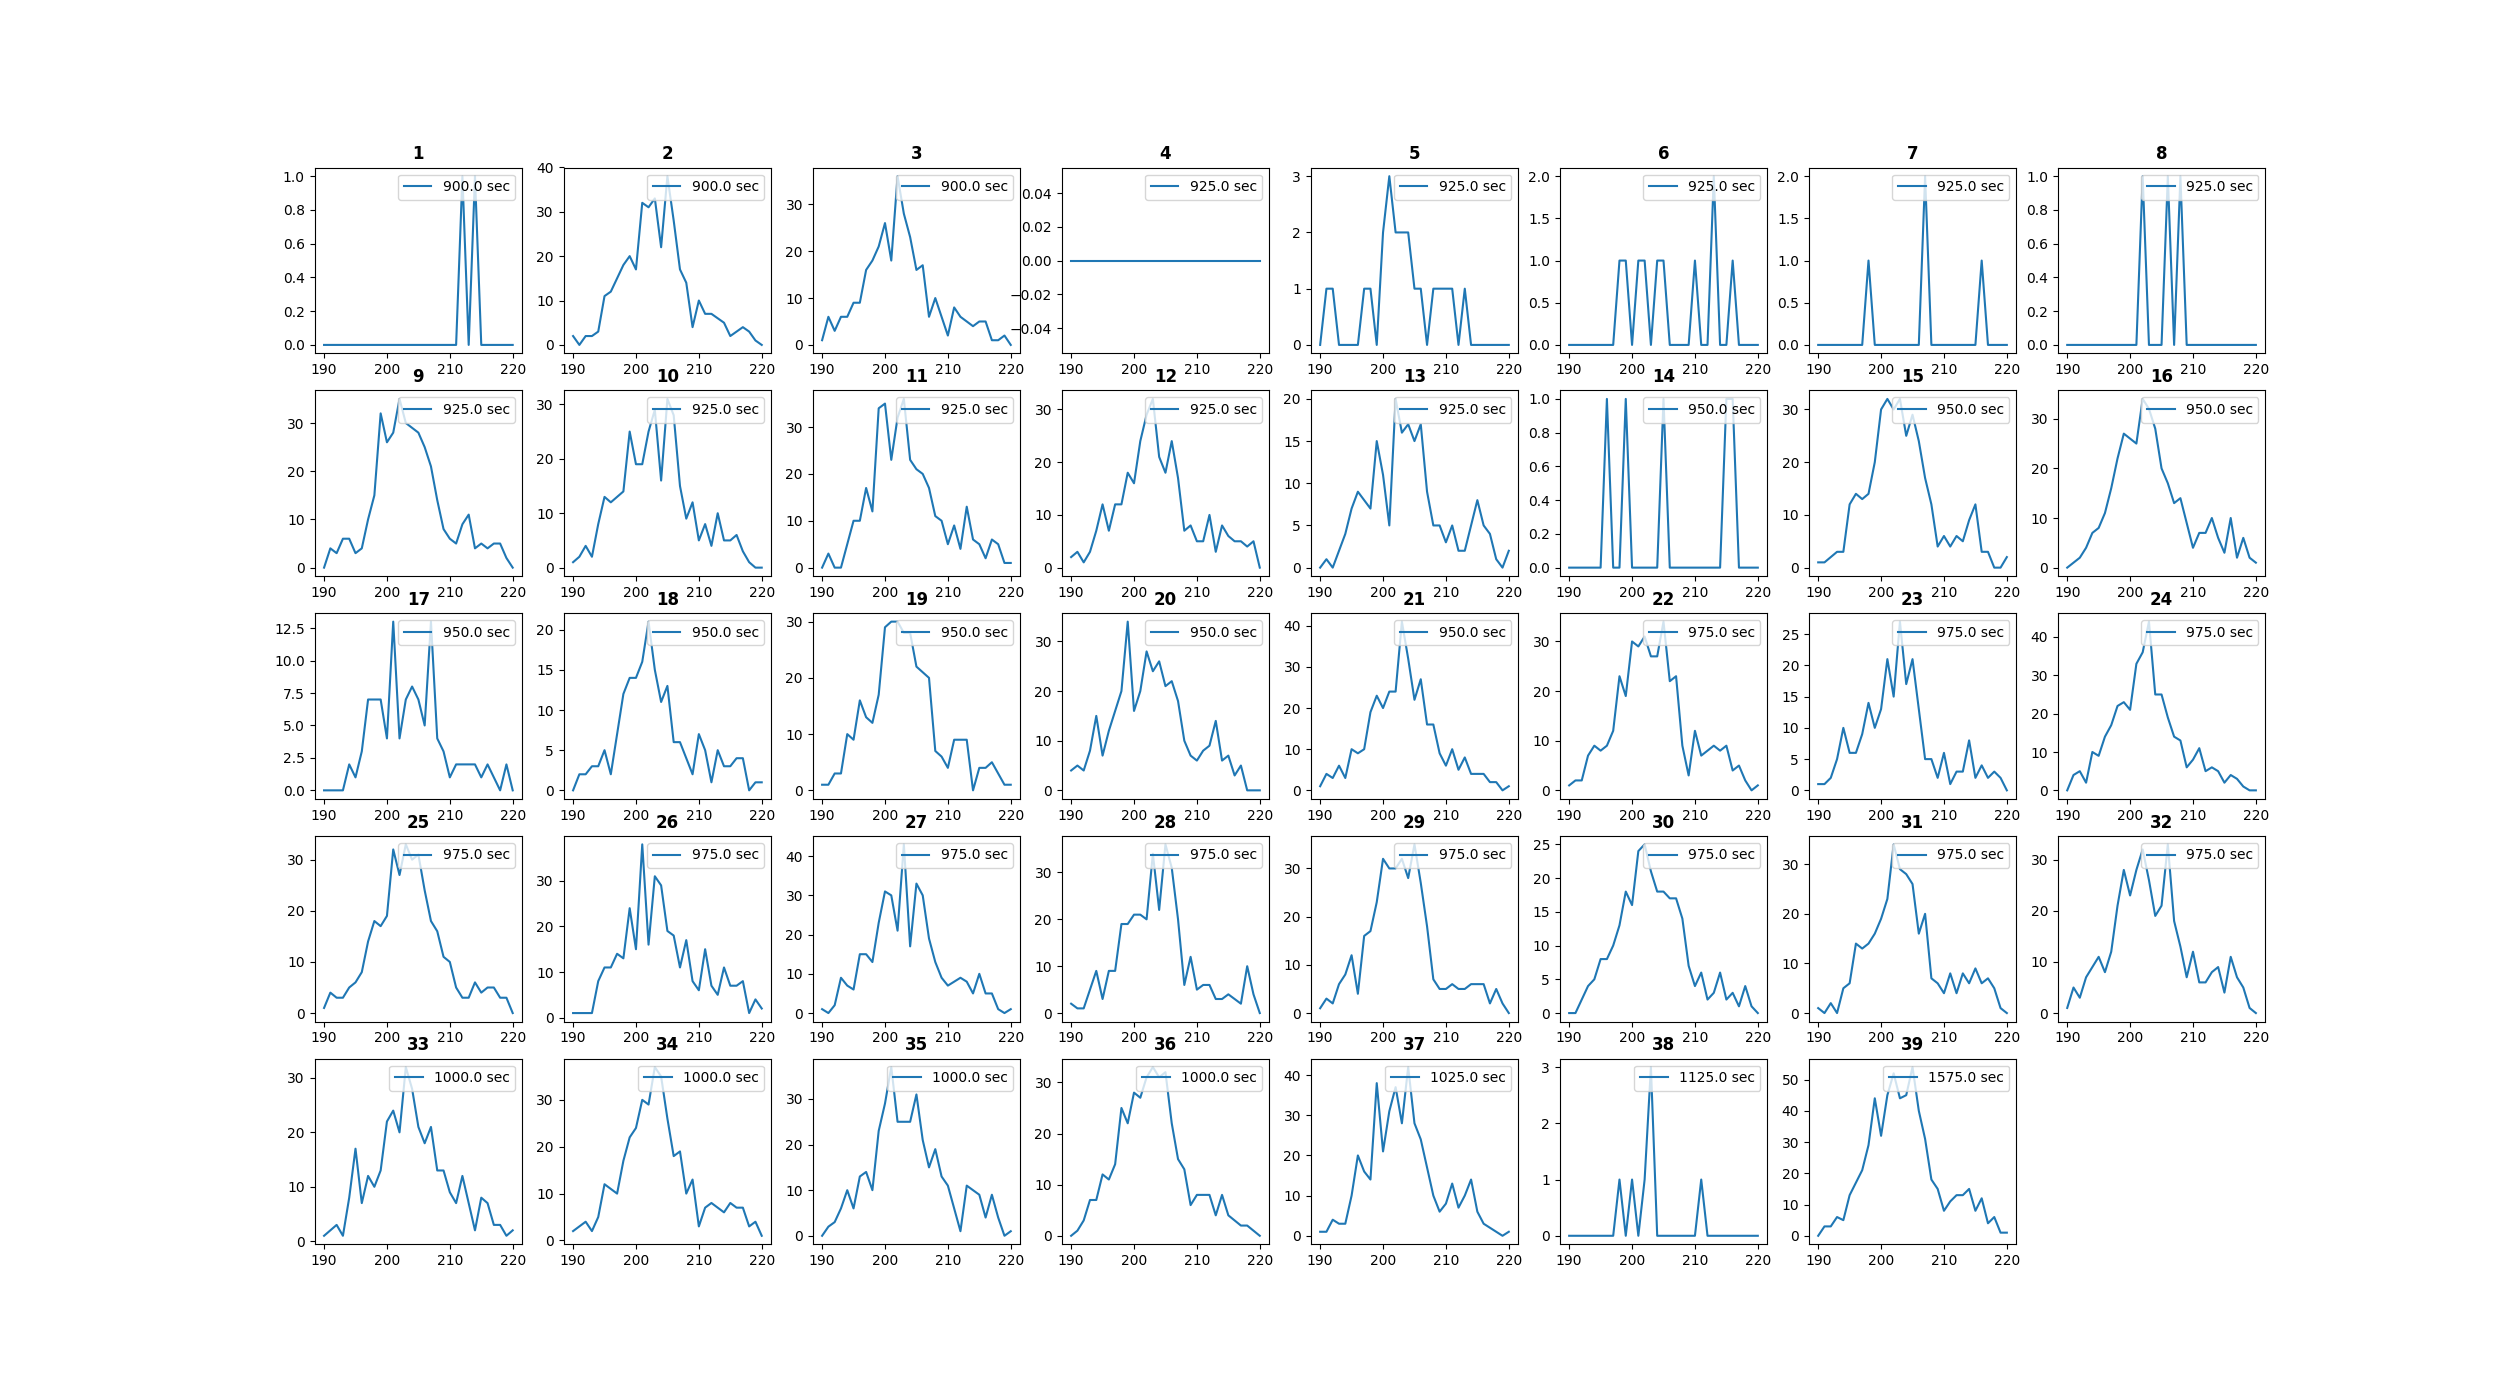

In [7]:
%matplotlib notebook
plot_events_all(eventsTimeList,ordered=1)

Ordered and removing low count histograms

<IPython.core.display.Javascript object>


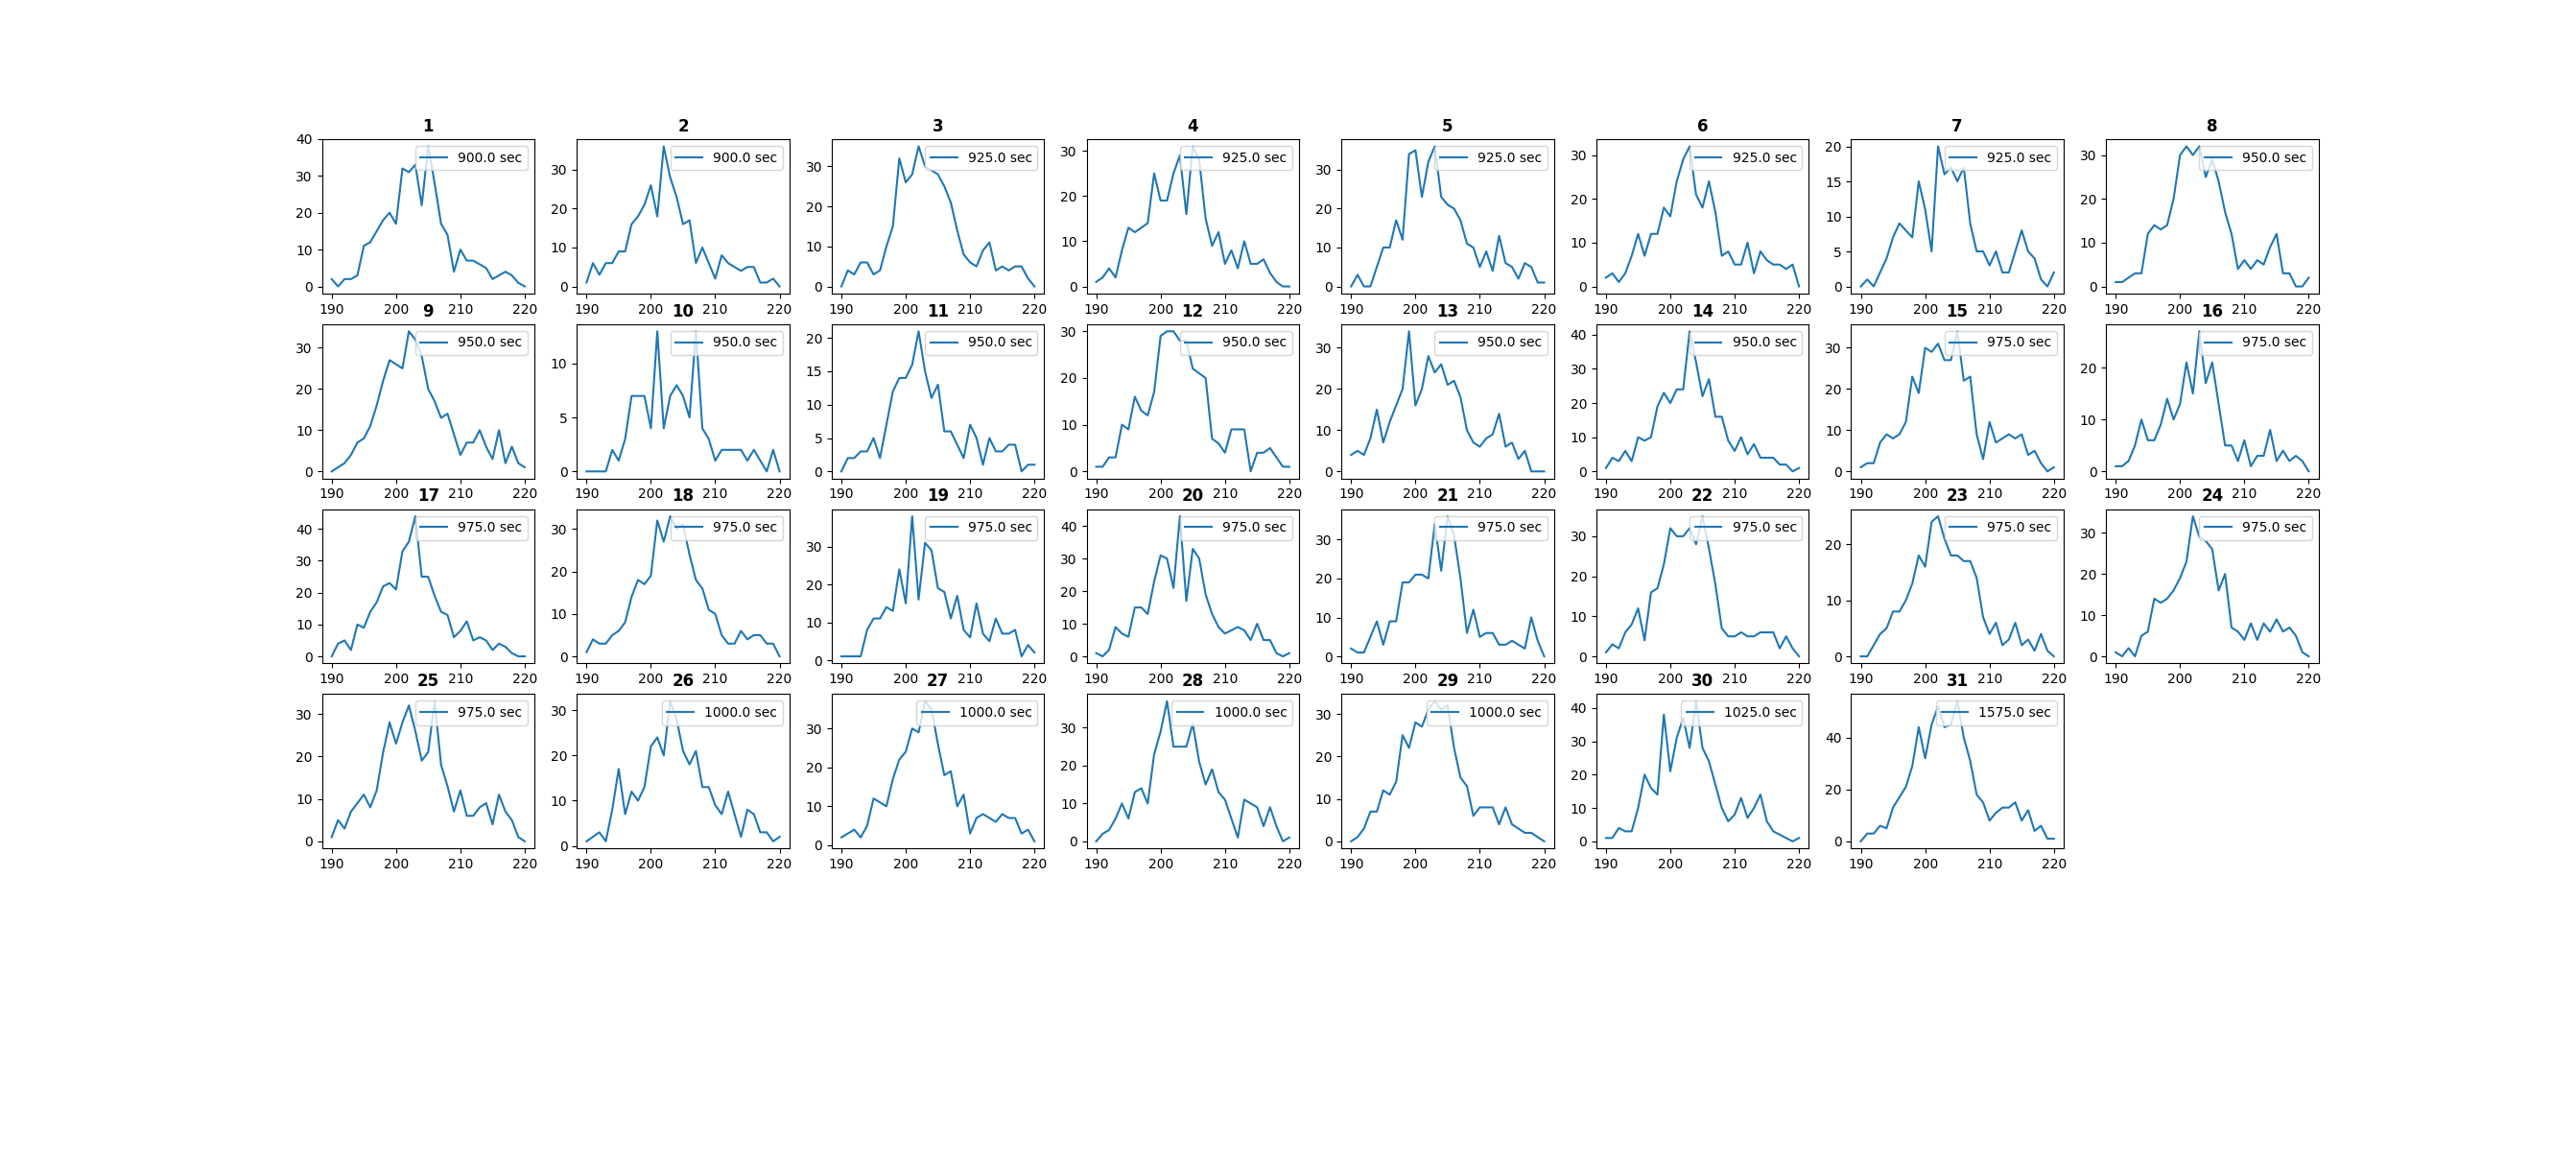

In [10]:
%matplotlib notebook
plot_events_all(eventsTimeList,ordered=1, removeBad=1)

# Fit parameters evolution
Gaussian fits and residuals for histograms grouped by time

<IPython.core.display.Javascript object>


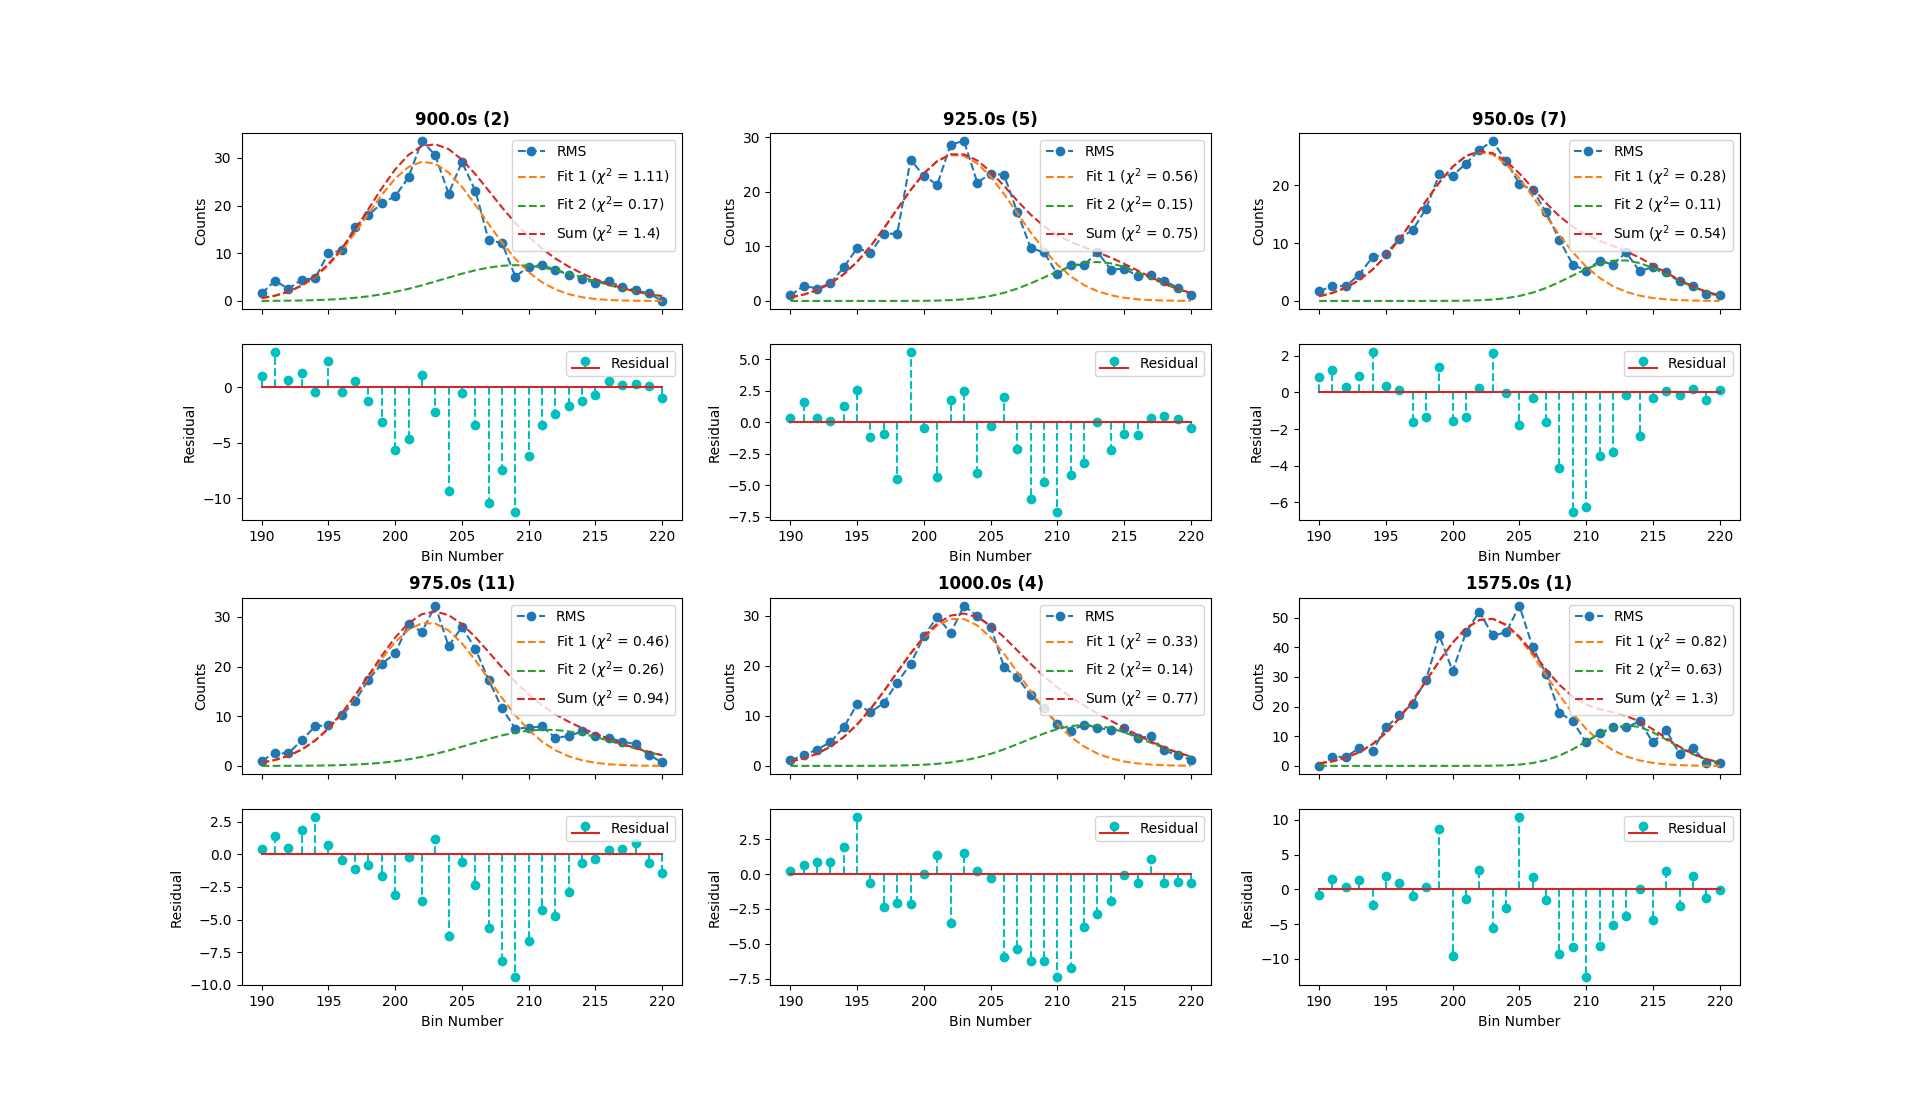

In [27]:
%matplotlib notebook
rms_fit_and_residual_fit(eventsTimeList,6,1,1,1)

Parameter evolution for each fit

<IPython.core.display.Javascript object>


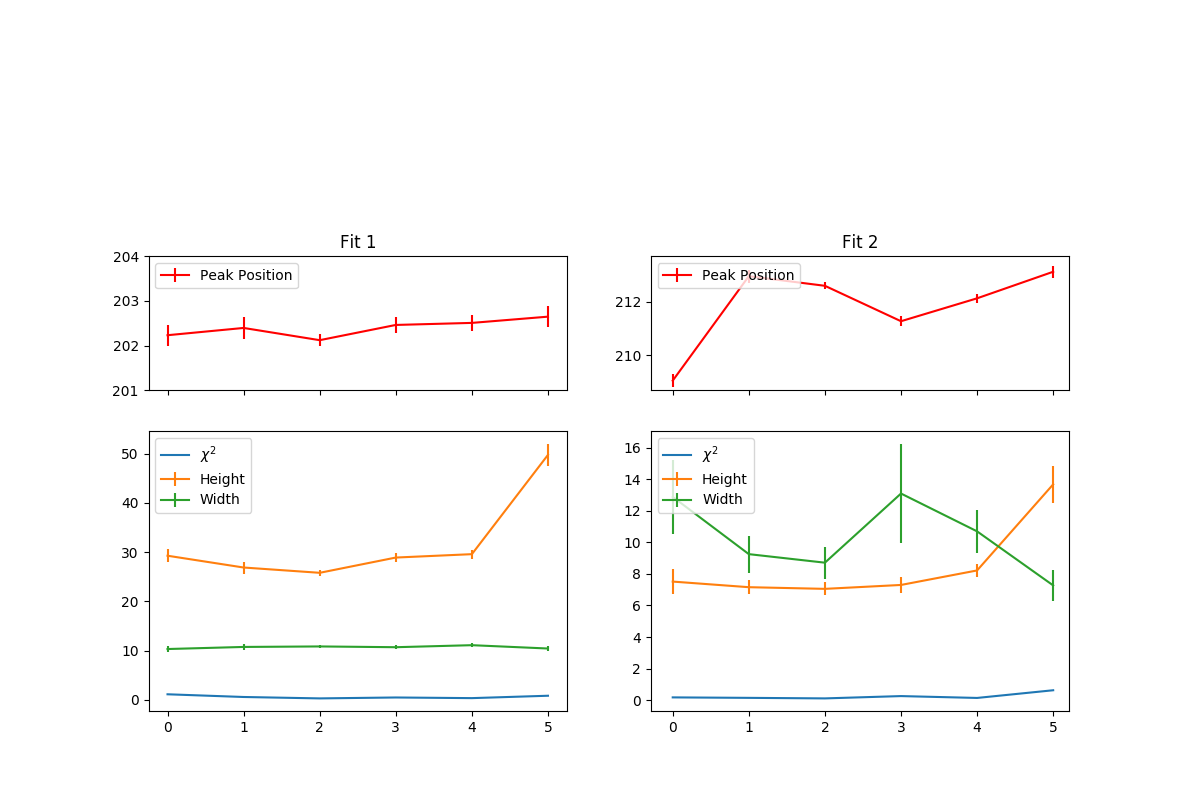

In [45]:
%matplotlib notebook
plot_fit_parameters(eventsTimeList, remover=1,groupByTime=1)

<IPython.core.display.Javascript object>


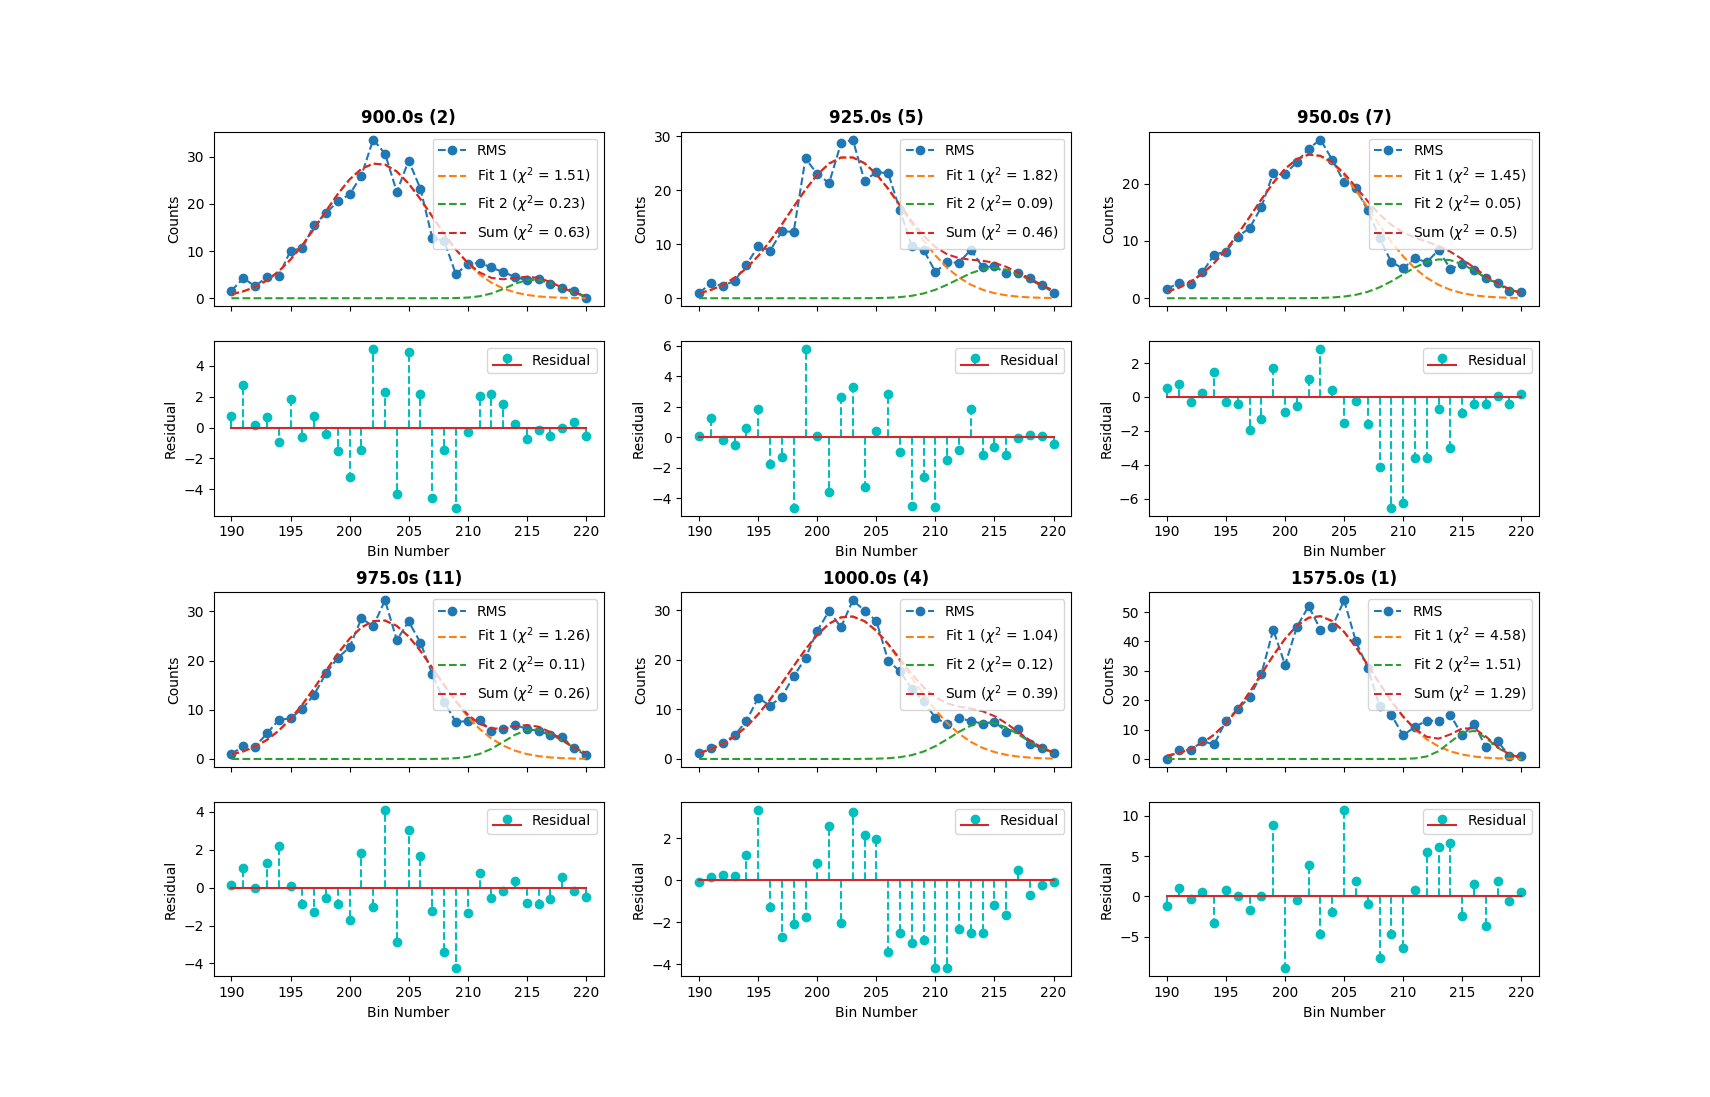

In [149]:
%matplotlib notebook
rms_fit_and_residual_fit(eventsTimeList,6,1,1,1)

<IPython.core.display.Javascript object>


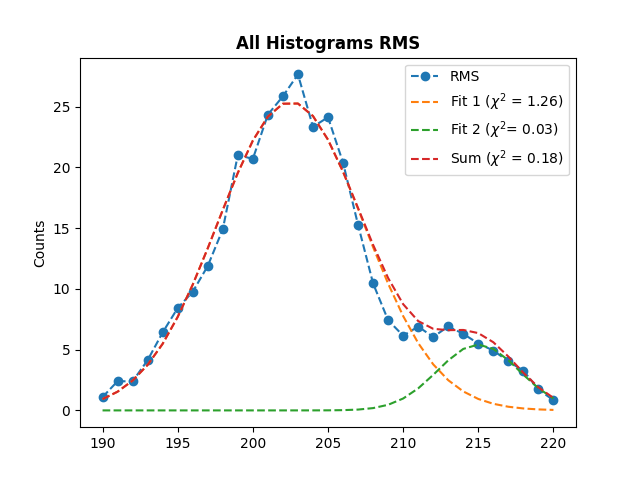

Text(0.5,1,u'All Histograms RMS')

In [151]:
%matplotlib notebook
fit_events_rms(eventsTimeList)
title("All Histograms RMS", fontweight = 'bold')

<IPython.core.display.Javascript object>


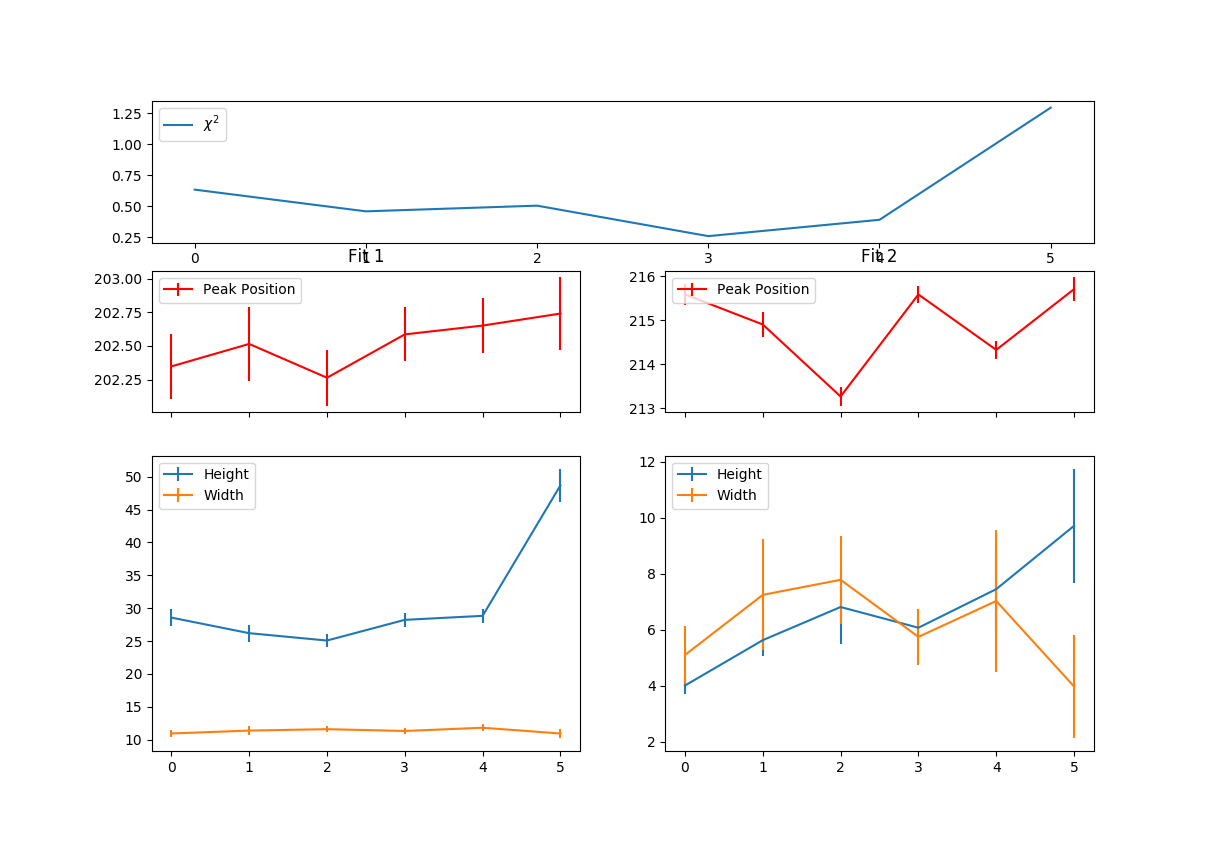

In [147]:
%matplotlib notebook
plot_fit_parameters(eventsTimeList, remover=1,groupByTime=1)